In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/databrain/Training/no_tumor/image(84).jpg
/kaggle/input/databrain/Training/no_tumor/image(44).jpg
/kaggle/input/databrain/Training/no_tumor/image(245).jpg
/kaggle/input/databrain/Training/no_tumor/6.jpg
/kaggle/input/databrain/Training/no_tumor/image(238).jpg
/kaggle/input/databrain/Training/no_tumor/image(196).jpg
/kaggle/input/databrain/Training/no_tumor/image(108).jpg
/kaggle/input/databrain/Training/no_tumor/image(310).jpg
/kaggle/input/databrain/Training/no_tumor/image (5).jpg
/kaggle/input/databrain/Training/no_tumor/image(186).jpg
/kaggle/input/databrain/Training/no_tumor/image(29).jpg
/kaggle/input/databrain/Training/no_tumor/image(140).jpg
/kaggle/input/databrain/Training/no_tumor/image(224).jpg
/kaggle/input/databrain/Training/no_tumor/image (61).jpg
/kaggle/input/databrain/Training/no_tumor/image(173).jpg
/kaggle/input/databrain/Training/no_tumor/image(52).jpg
/kaggle/input/databrain/Training/no_tumor/image (52).jpg
/kaggle/input/databrain/Training/no_tumor/ima

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input


In [3]:
import os

dataset_path = "/kaggle/input/databrain/Training"

if os.path.exists(dataset_path):
    print("Dataset directory exists.")
    print("Contents:", os.listdir(dataset_path))
else:
    print("Dataset directory does not exist.")


Dataset directory exists.
Contents: ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


In [4]:
dataset_path = "/kaggle/input/databrain/Training"

categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [5]:
X = []
y = []

for category in categories:
    class_index = categories.index(category)
    path = os.path.join(dataset_path, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(class_index)
        except Exception as e:
            print("error:", e)

X = np.array(X) / 255.0  # normalization
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print("train shape:", X_train.shape)
print("Test shape:", X_test.shape)


train shape: (2296, 224, 224, 3)
Test shape: (574, 224, 224, 3)


In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode="nearest"
)
datagen.fit(X_train)


In [7]:
# Load VGG16 model with pre-trained weights, excluding the top (fully connected) layers
vgg16_base = VGG16(weights='/kaggle/input/vgg_imagenet/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained VGG16 model
for layer in vgg16_base.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Modeli Derleme (Compile)**

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Reduced learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [10]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1) 

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.5177 - loss: 1.1334 - val_accuracy: 0.7927 - val_loss: 0.6103
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7728 - loss: 0.6050 - val_accuracy: 0.8293 - val_loss: 0.4704
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8143 - loss: 0.4832 - val_accuracy: 0.8537 - val_loss: 0.3854
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8590 - loss: 0.3919 - val_accuracy: 0.8624 - val_loss: 0.3508
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8752 - loss: 0.3514 - val_accuracy: 0.8693 - val_loss: 0.3381
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8843 - loss: 0.3255 - val_accuracy: 0.8833 - val_loss: 0.3038
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8919 - loss: 0.2806 - val_accuracy: 0.8868 - val_loss: 0.2956
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9085 - loss: 0.2580 - val_accuracy: 0.8955 -

**Modeli Test Etme**

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8891 - loss: 0.2794
Test Loss: 0.2440
Test Accuracy: 0.9059


**Confusion Matrix ve Classification Report**

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


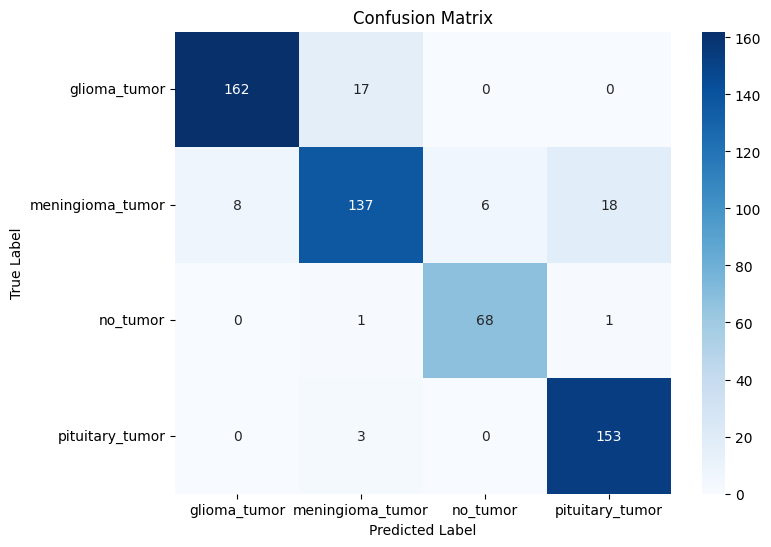

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.91      0.93       179
meningioma_tumor       0.87      0.81      0.84       169
        no_tumor       0.92      0.97      0.94        70
 pituitary_tumor       0.89      0.98      0.93       156

        accuracy                           0.91       574
       macro avg       0.91      0.92      0.91       574
    weighted avg       0.91      0.91      0.90       574



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))

In [13]:
# Load the image you want to predict
image_path = "/kaggle/input/databrain/Training/pituitary_tumor/p (106).jpg"  # Replace with the actual path to your image
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
img = np.array(img) / 255.0  # Normalize the image
img = np.expand_dims(img, axis=0)  # Add a batch dimension


In [14]:
# Make the prediction
prediction = model.predict(img)

# Get the predicted class
predicted_class = np.argmax(prediction, axis=1)[0]
predicted_label = categories[predicted_class]

# Print the prediction
print("Predicted class:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: pituitary_tumor


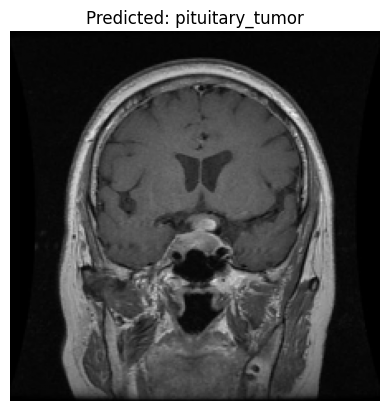

In [15]:
# Optionally, display the image
plt.imshow(img[0])
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()